# Julia Gaussian Process

Same as gaussian_process but in Julia

In [1]:
using LinearAlgebra
using Distances
using Plots
using Random

mutable struct GP{T<:AbstractFloat}
    kernel
    X::Array{T,2}
    Y::Array{T,1}
    S_XX_inv::Array{T,2}
    GP{T}(kernel, dim::Int) where {T<:AbstractFloat} = new(kernel, zeros(T, 0, dim), zeros(T, 0), zeros(T, 0, 0))
end    

function train!(gp::GP{T}, x::Array{T,1}, y::T) where {T<:AbstractFloat}
    
    if isempty(gp.Y)
        gp.S_XX_inv = inv(gp.kernel(x, x))
    else        
        S21 = gp.kernel(x, gp.X)
        SCinv = inv(gp.kernel(x, x) - S21 * gp.S_XX_inv * S21')
        Sinv12 = gp.S_XX_inv * S21' * SCinv
        Sinv11 = gp.S_XX_inv + Sinv12 * S21 * gp.S_XX_inv

        gp.S_XX_inv = [Sinv11 -Sinv12; -Sinv12' SCinv]
    end
    
    gp.X = vcat(gp.X, x)
    push!(gp.Y, y)
end

function predict(gp::GP{T}, x::Array{T,1}) where {T<:AbstractFloat}
    s_xX = gp.kernel(x, gp.X)
    
    mu_pred = s_xX * gp.S_XX_inv * gp.Y
    sig_pred = gp.kernel(x,x) - s_xX * gp.S_XX_inv * s_xX'
    
    return mu_pred[1], maximum([0. sig_pred[1]])
end

predict (generic function with 1 method)

In [2]:
sigma = 0.4
kernel(x1,x2) = exp.(-pairwise(Euclidean(), x1', x2', dims=2).^2/(2*sigma))
gp = GP{Float64}(kernel, 1)

unknown_fun(x) = sin.(3*x)
N_sample = 5
rng = MersenneTwister(2)

for i in 1:N_sample
    x = 5*rand(rng, 1)[1]
    train!(gp, [x], unknown_fun(x))
end

xx = -2:0.01:7
out = map(x -> predict(gp, [x]), xx)
yy, ss = map(x -> getindex.(out, x), 1:2);

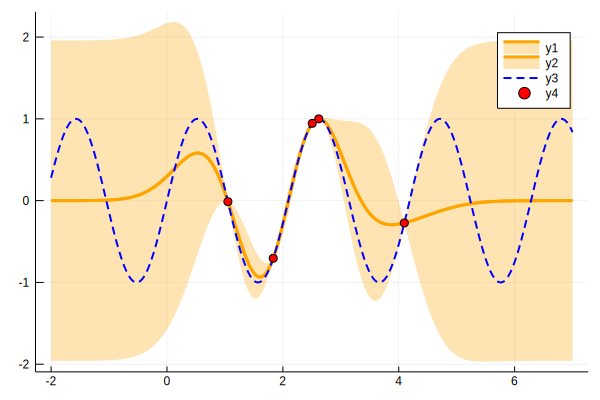

In [3]:
plot(xx, [yy, yy], fillrange=[yy+1.96*sqrt.(ss), yy-1.96*sqrt.(ss)],
     c=:orange, fillalpha=0.3, linewidth=3)
plot!(xx, unknown_fun(xx), c=:blue, linewidth=2, linestyle=:dash)
scatter!(gp.X, gp.Y, c=:red)